In [212]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

plt.rcParams['font.size'] = 18
wavelength, flux, err = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced/binned_data_a.npy')
wavelength2, flux2, err2 = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced2/binned_data2.npy')

times = np.load('/Users/arcticfox/Documents/AUMic/reduced/times.npy')
orbits = np.load('/Users/arcticfox/Documents/AUMic/reduced/orbits.npy')
times2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/times.npy')
orbits2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/orbits.npy')+5

wavelength = np.full(flux.shape, wavelength)
wavelength2 = np.full(flux2.shape, wavelength2)

np.append(flux, flux2, axis=0).shape

flare_mask = np.load('/Users/arcticfox/Documents/AUMic/flare_mask.npy',
                     allow_pickle=True)

parula = np.load('/Users/arcticfox/parula_colors.npy')#[np.linspace(0,210,len(times),dtype=int)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
fwc = FlaresWithCOS(wavelength=np.append(wavelength, wavelength2, axis=0), 
                    flux=np.append(flux, flux2, axis=0),
                    flux_err=np.append(err, err2, axis=0), 
                    time=np.append(times-times[0], times2-times2[0]), 
                    orbit=np.append(orbits, orbits2))
fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')

for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion=ion)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later


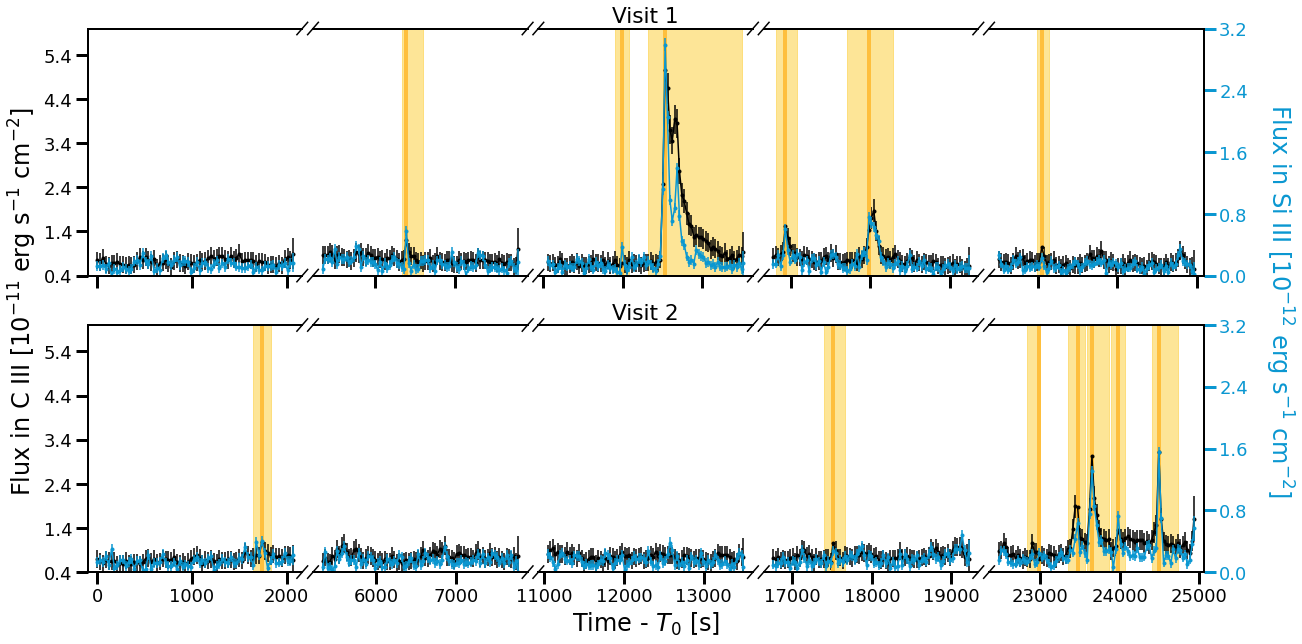

In [229]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,10))
ax = axes.reshape(-1)
fig.set_facecolor('w')

d = .025
c=100

mcolor = 'k'
scolor = parula[80]

for j in range(0,10):
    q = fwc.orbit == j
    ax[j].errorbar(fwc.time[q].value, 
                 fwc.width_table['CIII'][q].value, 
                 yerr=fwc.error_table['CIII'][q].value,
                 color=mcolor, marker='.')
    
    ax2 = ax[j].twinx()
    
    ax2.errorbar(fwc.time[q].value, 
                 fwc.width_table['SiIII'][q].value, 
                 yerr=fwc.error_table['SiIII'][q].value/10,
                 color=scolor, marker='.')
    
    if j in flare_mask[1]:
        inds = np.where(np.array(flare_mask[1])==j)[0]

        for n in inds:
            m = flare_mask[2][n] != 0
            ax[j].axvspan(fwc.time[m][0].value, 
                          fwc.time[m][-1].value, 0, 1,
                          color=parula[225], alpha=0.5)
            
            argmax = np.argmax(fwc.width_table['SiIII'][m])
            ax[j].vlines(fwc.time[m][argmax].value,
                         0, 1, color=parula[215], lw=4)

            c += 15
    
    if j!=0 and j !=4 and j!=5 and j !=9:
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['left'].set_visible(False)
        ax[j].set_yticks([])
        
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.set_yticks([])
        
        kwargs = dict(transform=ax[j].transAxes, color='k', clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        
    elif j == 0 or j == 5:
        ax[j].spines['right'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.set_yticks([])
        
        kwargs = dict(transform=ax[j].transAxes, color='k', clip_on=False)
        ax[j].plot((1-d,1+d), (-d,+d), **kwargs)
        ax[j].plot((1-d,1+d),(1-d,1+d), **kwargs)
    else:
        ax[j].spines['left'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax[j].set_yticks([])
        #ax2.set_yticks([])
        
        kwargs.update(transform=ax[j].transAxes)  # switch to the bottom axes
        ax[j].plot((-d,+d), (1-d,1+d), **kwargs)
        ax[j].plot((-d,+d), (-d,+d), **kwargs)
        

    if j == 2:
        ax[j].set_title('Visit 1')#, fontsize=)
    if j == 7:
        ax[j].set_title('Visit 2')
        ax[j].set_xlabel('Time - $T_0$ [s]', fontsize=24)

    if j < 5:
        ax[j].set_xticklabels([])

    if j == 0 or j == 5:
        yticks = np.arange(0.4e-11,6e-11,1e-11)
        ax[j].set_yticks(yticks)
        ax[j].set_yticklabels(np.round(yticks/1e-11, 2))
    if j < 5:
        ax[j].set_xticklabels([])
        ax[j].set_ylim(0.4e-11, 6e-11)
        ax2.set_ylim(0.2e-13, 3e-12)
    else:
        ax[j].set_ylim(0.4e-11, 6e-11)
        ax2.set_ylim(0.2e-13, 3e-12)
    if j == 9 or j == 4:
        yticks = np.arange(0.2e-13, 3.5e-12,8e-13)
        ax2.set_yticks(yticks)
        ax2.tick_params(axis='y', colors=scolor)
        ax2.set_yticklabels(np.round(yticks/1e-12, 1), color=scolor)
        
    if j == 5:
        ax[j].set_ylabel('Flux in C III [$10^{-11}$ erg s$^{-1}$ cm$^{-2}$]', 
                         fontsize=24, y=1.1)
    if j == 9:
        ax[j].set_ylabel('Flux in Si III [$10^{-12}$ erg s$^{-1}$ cm$^{-2}$]\n\n\n\n\n\n\n\n\n\n', 
                       fontsize=24, y=1.1, color=scolor, rotation=270)
    ax[j].set_rasterized(True)
        
plt.subplots_adjust(wspace=0.05)
plt.savefig('/Users/arcticfox/Documents/AUMic/paper/flares.pdf',
            rasterize=True, bbox_inches='tight', dpi=300)

In [223]:
inds

array([0])